In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- PARÂMETROS ----------
TICKERS_ACOES = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "WEGE3.SA", "ABEV3.SA"]
TICKER_IBOV = "^BVSP"
DATA_INICIO = "2023-01-01"
DATA_FIM = "2024-01-01"

""" importante ressaltar que existe a composição do ibov, objetivo é replicar o ibov, não a composição dele e avaliar como cada ação influencia no ibov"""


In [2]:
def baixar_dados(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df[["Close"]].rename(columns={"Close": ticker})
    return df

def coletar_todos(tickers, start, end):
    dfs = [baixar_dados(t, start, end) for t in tickers]
    return pd.concat(dfs, axis=1, join="inner")

In [3]:
def calcular_retorno(df_precos):
    return df_precos.pct_change().dropna()


In [4]:
def resolver_sel(X, y):
    resultado = lsq_linear(X, y, bounds=(0, 1))  # pesos entre 0 e 1 Metodos dos minimos quadrados
    return resultado.x


'''CCO: Aplicações do Método dos Mínimos Quadrados Lineares:

Ajuste de Curvas e Superfícies: Utilizado para modelar relações entre variáveis em experimentos científicos, permitindo prever comportamentos futuros com base em dados históricos.

Análise de Regressão Linear: Empregado para entender a relação entre uma variável dependente e uma ou mais variáveis independentes, facilitando a identificação de tendências e correlações nos dados.

Processamento de Sinais: Aplicado na filtragem e suavização de sinais ruidosos, melhorando a qualidade das informações extraídas.'''

'CCO: Aplicações do Método dos Mínimos Quadrados Lineares:\n\nAjuste de Curvas e Superfícies: Utilizado para modelar relações entre variáveis em experimentos científicos, permitindo prever comportamentos futuros com base em dados históricos.\n\nAnálise de Regressão Linear: Empregado para entender a relação entre uma variável dependente e uma ou mais variáveis independentes, facilitando a identificação de tendências e correlações nos dados.\n\nProcessamento de Sinais: Aplicado na filtragem e suavização de sinais ruidosos, melhorando a qualidade das informações extraídas.'

In [5]:
def avaliar_modelo(y_real, y_pred, nome="Ibov"):
    print(f"\n Avaliação - {nome}")
    print("MAE:", mean_absolute_error(y_real, y_pred))
    print("RMSE:", mean_squared_error(y_real, y_pred, squared=False))
    print("R²:", r2_score(y_real, y_pred))

    curva_real = (1 + y_real).cumprod()
    curva_replicada = (1 + y_pred).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(curva_real, label="Ibov Real", linewidth=2)
    plt.plot(curva_replicada, label="Ibov Replicado (SEL)", linestyle='--')
    plt.title("Curva Acumulada: Ibov vs SEL")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def aplicar_pca(X, tickers, n_componentes=3):
    pca = PCA(n_components=n_componentes)
    pca.fit(X)

    print("\n PCA - Variância explicada:")
    print(pca.explained_variance_ratio_)

    print("\n Componentes principais (loadings):")
    df_componentes = pd.DataFrame(pca.components_, columns=tickers)
    print(df_componentes)

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, n_componentes + 1), pca.explained_variance_ratio_,
            tick_label=[f"PC{i}" for i in range(1, n_componentes + 1)])
    plt.title("Variância Explicada por Componente Principal")
    plt.xlabel("Componente")
    plt.ylabel("Proporção da Variância")
    plt.grid(True)
    plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Pesos estimados:
PETR4.SA: 0.1495
VALE3.SA: 0.2013
ITUB4.SA: 0.3556
WEGE3.SA: 0.1310
ABEV3.SA: 0.1273

 Avaliação - Ibov
MAE: 0.003368711928333405
RMSE: 0.004264880756459444
R²: 0.8401061295921952


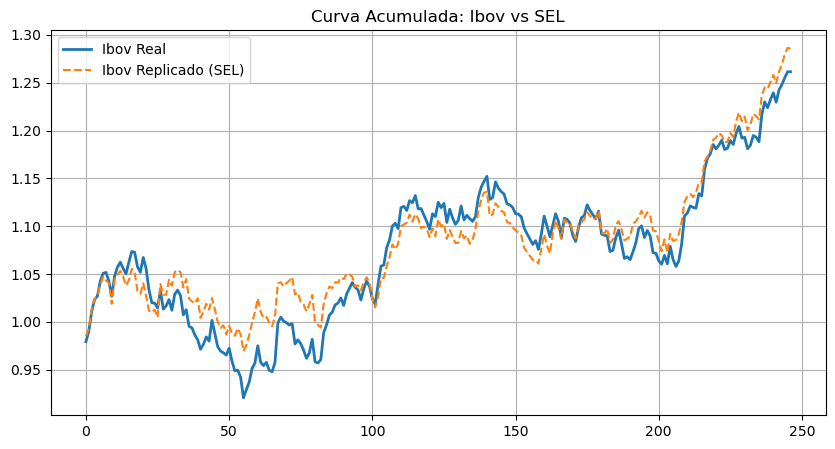


 PCA - Variância explicada:
[0.38598757 0.22611098 0.16734749]

 Componentes principais (loadings):
   PETR4.SA  VALE3.SA  ITUB4.SA  WEGE3.SA  ABEV3.SA
0  0.729947  0.434040  0.386278  0.228550  0.278102
1  0.598463 -0.258355 -0.240192 -0.656152 -0.294732
2 -0.227236  0.847222 -0.099270 -0.381080 -0.274777


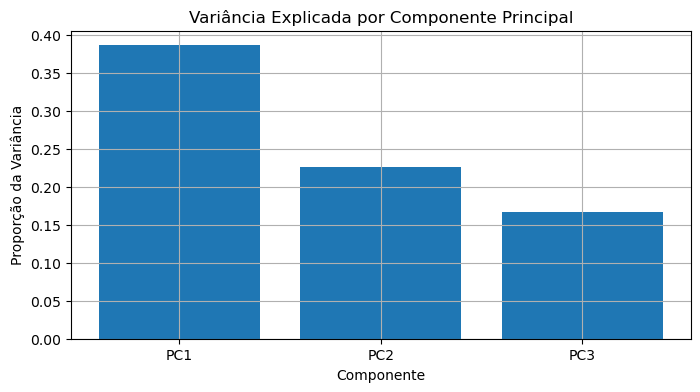

In [7]:
# Pipeline principal 
df_acoes = coletar_todos(TICKERS_ACOES, DATA_INICIO, DATA_FIM)
df_ibov = baixar_dados(TICKER_IBOV, DATA_INICIO, DATA_FIM)

df_retorno_acoes = calcular_retorno(df_acoes)
df_retorno_ibov = calcular_retorno(df_ibov)

df_merged = pd.merge(df_retorno_ibov, df_retorno_acoes, left_index=True, right_index=True)

y = df_merged[TICKER_IBOV].values.ravel()
X = df_merged[TICKERS_ACOES].values

pesos = resolver_sel(X, y)

print("Pesos estimados:")
for t, p in zip(TICKERS_ACOES, pesos):
    print(f"{t}: {p:.4f}")

y_pred = np.dot(X, pesos)  # existe a opção de multiplicacao matricial por y_pred = X @ pesos


avaliar_modelo(y, y_pred, nome="Ibov")
aplicar_pca(X, TICKERS_ACOES)
